# Adversarial Machine Learning Experiment: IDS Robustness Testing

This notebook demonstrates a comprehensive adversarial machine learning experiment on an Intrusion Detection System (IDS) using the NSL-KDD dataset.

## Experiment Overview

**Phases:**
1. **Baseline Model Training** - Train a standard DNN-based IDS
2. **White-Box PGD Attacks** - Test worst-case adversarial vulnerability
3. **Black-Box Transfer Attacks** - Evaluate transferability from surrogate models
4. **Adversarial Training** - Implement defense mechanism
5. **Comprehensive Evaluation** - Compare baseline vs robust models

**Key Techniques:**
- Projected Gradient Descent (PGD) attack
- Feature-constrained attacks (preserve one-hot encodings)
- Transfer attacks with ensemble methods
- Adversarial training following Madry et al.

**Dataset:** NSL-KDD (Binary classification: Normal vs Attack)

## 1. Environment Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from pathlib import Path
import sys
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Add main directory to path for imports
sys.path.insert(0, os.path.join(os.getcwd(), 'main'))

# Set random seeds for reproducibility
seed = 9281
np.random.seed(seed)
tf.random.set_seed(seed)

# Create directories for outputs
Path('models').mkdir(exist_ok=True)
Path('results').mkdir(exist_ok=True)
Path('adversarial_data').mkdir(exist_ok=True)

print("✓ All imports successful!")
print(f"TensorFlow version: {tf.__version__}")

## 2. Data Loading and Preprocessing

- feature cleaning
- one hot encoding
- scaling


In [ ]:
from sklearn.model_selection import train_test_split



NSL_KDD_COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'outcome', 'level'
]

CATEGORICAL_COLUMNS = ['protocol_type', 'service', 'flag']
TARGET_COLUMN = 'outcome'
DROP_COLUMNS = ['outcome', 'level']


def load_data(filepath):
    df = pd.read_csv(filepath, header=None)
    df.columns = NSL_KDD_COLUMNS
    return df

def preprocess_nsl_kdd(df, scaler=None, feature_columns=None):
    df = df.copy()

    for col in ['duration', 'wrong_fragment']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.fillna(0)

    df[TARGET_COLUMN] = (df[TARGET_COLUMN] != "normal").astype(int)
    y = df[TARGET_COLUMN].values

    df = pd.get_dummies(df, columns=CATEGORICAL_COLUMNS, drop_first=False)

    if feature_columns is not None:
        df = df.reindex(columns=list(feature_columns) + DROP_COLUMNS, fill_value=0)
    else:
        feature_columns = df.drop(DROP_COLUMNS, axis=1).columns.tolist()

    X = df.drop(DROP_COLUMNS, axis=1).values.astype(np.float32)

    if scaler is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)

    return X, y, scaler, feature_columns

df = load_data('KDDTrain+.txt')
# Split the loaded training dataframe into train/test (80/20) with stratification
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=seed,
    stratify=df[TARGET_COLUMN]
)
X_train, y_train, scaler, feature_columns = preprocess_nsl_kdd(
    df_train,
)

X_test, y_test, _, _ = preprocess_nsl_kdd(
    df_test,
    scaler=scaler,
    feature_columns=feature_columns
)

print(f"✓ Data loaded and preprocessed!")
print(f"  Training shape: {X_train.shape}")
print(f"  Test shape: {X_test.shape}")

n_features = X_train.shape[1]
n_categorical = 3 + 70 + 11  # protocol_type + service + flag = 84
n_continuous = n_features - n_categorical

continuous_idx = list(range(n_continuous))
onehot_idx = list(range(n_continuous, n_features))
print(f"\nFeature indices:")
print(f"  Continuous features: {n_continuous} (indices 0 to {n_continuous-1})")
print(f"  One-hot features:    {n_categorical} (indices {n_continuous} to {n_features-1})")

## 3. Baseline IDS Model Architecture

regularization techniques:

- batch norm
- dropout
- l2 regularization
- adam optimizer
- early stopping
- reduce LR
- batch norm?
- class weights (is it regularization?)

In [ ]:
def build_baseline_ids_model(input_dim, name="baseline_ids"):
    """
    Standard IDS model (non-robust)
    Architecture: Dense network with batch normalization
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),

        # First block
        tf.keras.layers.Dense(128, activation=None,
                             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        # Second block
        tf.keras.layers.Dense(64, activation=None,
                             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4),

        # Third block
        tf.keras.layers.Dense(32, activation=None,
                             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.3),

        # Output
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name=name)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )

    return model

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\n  Class weights: {class_weight_dict}")

print("Training Baseline Model")

model_baseline = build_baseline_ids_model(X_train.shape[1])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history_baseline = model_baseline.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=1024,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model_baseline.save('models/baseline_ids_model.h5')
print("\n Baseline model saved to 'models/baseline_ids_model.h5'")
model_baseline.summary()

## 4. Baseline Model Evaluation

In [ ]:
def evaluate_model_comprehensive(model, X, y, model_name="Model"):
    """
    Comprehensive evaluation metrics for model performance

    Args:
        model: Trained model to evaluate
        X: Input features
        y: True labels
        model_name: Name for display

    Returns:
        Dictionary with accuracy, AUC, predictions, and probabilities
    """
    print(f"\n{'='*80}")
    print(f"{model_name} - Performance")
    print(f"{'='*80}")

    y_pred_prob = model.predict(X, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracy = (y_pred == y).mean()
    auc = roc_auc_score(y, y_pred_prob)

    print(f"\nOverall Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC: {auc:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y, y_pred,
                                target_names=['Normal', 'Attack'],
                                digits=4))

    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y, y_pred)
    print(f"                 Predicted")
    print(f"                Normal  Attack")
    print(f"Actual Normal   {cm[0,0]:6d}  {cm[0,1]:6d}")
    print(f"       Attack   {cm[1,0]:6d}  {cm[1,1]:6d}")

    return {
        'accuracy': accuracy,
        'auc': auc,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }

print("✅ Evaluation function defined!")
baseline_results = evaluate_model_comprehensive(
    model_baseline, X_test, y_test,
    "Baseline IDS Model - Clean Data"
)

## 5. White-Box PGD Attack Generation and Evaluation

**Semantic Constraints**
1. Count features → Round to integers (can't have 7.83 connections)
2. Binary flags → Project to {0,1} (logged_in must be 0 or 1)
3. Non-negative features** → Clip >= 0 (bytes, duration cannot be negative)
4. Rate features → Clip to [0,1] (error rates cannot exceed 100%)

For categorical, it is important to have realistic one hot encoding pertubation. This is done by applyingthe perturbation to groups, then projecting the highest new value as the new chosen class, and setting the others to 0
- Original: [tcp=1, udp=0, icmp=0]
- After perturbation: [tcp=0.3, udp=0.8, icmp=0.1]
- After projection: [tcp=0, udp=1, icmp=0]

In [ ]:
# Define semantic constraint indices
COUNT_FEATURE_INDICES = [
    0,  # duration - actually continuous, not count
    10,  # num_failed_logins
    12,  # num_compromised
    15,  # num_root
    16,  # num_file_creations
    17,  # num_shells
    18,  # num_access_files
    19,  # num_outbound_cmds
    22,  # count
    23,  # srv_count
    31,  # dst_host_count
    32,  # dst_host_srv_count
]

BINARY_FLAG_INDICES = [
    6,   # land
    9,   # hot
    8,   # urgent
    7,   # wrong_fragment
    10,  # num_failed_logins (often 0/1)
    11,  # logged_in
    13,  # root_shell
    14,  # su_attempted
    20,  # is_host_login
    21,  # is_guest_login
]

NON_NEGATIVE_INDICES = [
    0,   # duration
    4,   # src_bytes
    5,   # dst_bytes
]

RATE_FEATURE_INDICES = list(range(24, 40))  # All rate features (serror_rate through dst_host_srv_rerror_rate)

# Define one-hot encoded feature groups
# After one-hot encoding: 38 continuous features + 84 one-hot features
# protocol_type: 3 values (tcp, udp, icmp)
# service: 70 values
# flag: 11 values
ONEHOT_GROUPS = {
    'protocol_type': list(range(38, 41)),      # indices 38-40 (3 values)
    'service': list(range(41, 111)),           # indices 41-110 (70 values)
    'flag': list(range(111, 122))              # indices 111-121 (11 values)
}

print("One-hot feature groups:")
for name, indices in ONEHOT_GROUPS.items():
    print(f"  {name}: {len(indices)} categories, indices {indices[0]}-{indices[-1]}")


def pgd_attack_semantic_constrained(model, X, y, epsilon, alpha, num_iter,
                                    continuous_indices, onehot_groups,
                                    count_indices, binary_indices,
                                    nonneg_indices, rate_indices,
                                    scaler, random_start=True,
                                    allow_onehot_flip=True):
    """
    PGD attack with FULL semantic constraints for NSL-KDD.

    Constraints applied at EACH iteration AFTER gradient update:
    1. One-hot features:
       - If allow_onehot_flip=True: Allow flipping to nearest category within group
       - If allow_onehot_flip=False: No perturbation (original behavior)
    2. Count features: Round to integers (11 features)
    3. Binary flags: Project to {0,1} (9 features)
    4. Non-negative: Clip >= 0 in original space (3 features)
    5. Rate features: Clip to [0,1] in original space (15 features)
    """
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tensor = tf.cast(tf.convert_to_tensor(y), dtype=tf.float32)

    # Initialize perturbation
    if random_start:
        delta = tf.random.uniform(
            shape=X_tensor.shape,
            minval=-epsilon,
            maxval=epsilon,
            dtype=tf.float32
        )
    else:
        delta = tf.zeros_like(X_tensor)

    delta = tf.Variable(delta, trainable=True)

    # If not allowing one-hot flips, zero them out initially
    if not allow_onehot_flip:
        delta_np = delta.numpy()
        for group_indices in onehot_groups.values():
            delta_np[:, group_indices] = 0
        delta.assign(delta_np)

    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(delta)

            # Adversarial input (constraints will be applied AFTER gradient update)
            X_adv = X_tensor + delta

            # Compute loss (we want to MAXIMIZE loss to fool the model)
            predictions = model(X_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(
                y_tensor,
                tf.squeeze(predictions)
            )
            loss = tf.reduce_mean(loss)

        # Compute gradient
        gradient = tape.gradient(loss, delta)

        # Take step in direction of POSITIVE gradient (gradient ASCENT to maximize loss)
        delta_update = alpha * tf.sign(gradient)
        delta.assign_add(delta_update)

        # Project back to epsilon ball
        delta.assign(tf.clip_by_value(delta, -epsilon, epsilon))

        # Get numpy array for constraint application
        delta_np = delta.numpy()
        X_adv_np = X + delta_np

        # Apply one-hot constraints
        if allow_onehot_flip:
            X_adv_np = apply_onehot_constraints(X_adv_np, X, onehot_groups)
        else:
            # Zero out perturbations on one-hot features (original behavior)
            for group_indices in onehot_groups.values():
                delta_np[:, group_indices] = 0
            X_adv_np = X + delta_np

        # Apply other semantic constraints
        X_adv_constrained = apply_semantic_constraints_inline(
            X_adv_np, scaler,
            count_indices, binary_indices,
            nonneg_indices, rate_indices
        )

        # Update delta to reflect constrained version
        delta_np = X_adv_constrained - X
        delta.assign(delta_np)

    # Final adversarial examples
    X_adv = X_tensor + delta
    return X_adv.numpy()


def apply_onehot_constraints(X_adv, X_original, onehot_groups):
    """
    Project perturbed one-hot features back to valid one-hot encodings.

    For each one-hot group (e.g., protocol_type: [tcp, udp, icmp]):
    - Take the perturbed values in that group
    - Find the category with maximum value
    - Set that category to 1, all others to 0

    This allows the attack to "flip" categories if the perturbation is strong enough.

    Args:
        X_adv: Perturbed features [n_samples, n_features]
        X_original: Original features [n_samples, n_features]
        onehot_groups: Dict of {group_name: [indices]} for each categorical feature

    Returns:
        X_constrained: Features with valid one-hot encodings
    """
    X_constrained = X_adv.copy()

    for group_name, group_indices in onehot_groups.items():
        # For each sample, project the perturbed one-hot group back to valid one-hot
        for i in range(len(X_constrained)):
            # Get perturbed values in this one-hot group
            perturbed_values = X_constrained[i, group_indices]

            # Find the category with maximum value (winner-takes-all)
            max_idx = np.argmax(perturbed_values)

            # Create valid one-hot encoding
            new_onehot = np.zeros(len(group_indices))
            new_onehot[max_idx] = 1.0

            # Update the features with valid one-hot
            X_constrained[i, group_indices] = new_onehot

    return X_constrained


def apply_semantic_constraints_inline(X_adv, scaler,
                                count_indices, binary_indices,
                                nonneg_indices, rate_indices):
    """
    Apply semantic constraints without needing X_original.
    Simplified version for inline use during attack generation.
    """
    X_constrained = X_adv.copy()

    # 1. Count features: Round to integers in original space
    for idx in count_indices:
        if idx < X_constrained.shape[1]:
            mean = scaler.mean_[idx] if hasattr(scaler, 'mean_') else 0
            std = scaler.scale_[idx] if hasattr(scaler, 'scale_') else 1

            # Denormalize to original space
            original_val = X_constrained[:, idx] * std + mean

            # Round to nearest integer
            rounded_val = np.round(original_val)

            # Renormalize back
            X_constrained[:, idx] = (rounded_val - mean) / std if std > 0 else rounded_val

    # 2. Binary flags: Project to {0, 1} in normalized space
    for idx in binary_indices:
        if idx < X_constrained.shape[1]:
            mean = scaler.mean_[idx] if hasattr(scaler, 'mean_') else 0
            std = scaler.scale_[idx] if hasattr(scaler, 'scale_') else 1

            norm_0 = (0 - mean) / std if std > 0 else 0
            norm_1 = (1 - mean) / std if std > 0 else 1

            # Project to nearest {norm_0, norm_1}
            mid_point = (norm_0 + norm_1) / 2
            X_constrained[:, idx] = np.where(
                X_constrained[:, idx] < mid_point,
                norm_0,
                norm_1
            )

    # 3. Non-negative features: Clip to >= 0 in original space
    for idx in nonneg_indices:
        if idx < X_constrained.shape[1]:
            mean = scaler.mean_[idx] if hasattr(scaler, 'mean_') else 0
            std = scaler.scale_[idx] if hasattr(scaler, 'scale_') else 1

            # Normalized value corresponding to 0 in original space
            norm_zero = (0 - mean) / std if std > 0 else 0

            # Clip to be >= norm_zero
            X_constrained[:, idx] = np.maximum(X_constrained[:, idx], norm_zero)

    # 4. Rate features [0, 1]: Clip in normalized space
    for idx in rate_indices:
        if idx < X_constrained.shape[1]:
            mean = scaler.mean_[idx] if hasattr(scaler, 'mean_') else 0
            std = scaler.scale_[idx] if hasattr(scaler, 'scale_') else 1

            norm_0 = (0 - mean) / std if std > 0 else 0
            norm_1 = (1 - mean) / std if std > 0 else 1

            # Clip to [norm_0, norm_1]
            X_constrained[:, idx] = np.clip(X_constrained[:, idx],
                                            min(norm_0, norm_1),
                                            max(norm_0, norm_1))

    return X_constrained


def generate_adversarial_batched_semantic(model, X, y, batch_size,
        epsilon, alpha, num_iter, continuous_indices, onehot_groups,
        count_indices, binary_indices, nonneg_indices, rate_indices,
        scaler, random_start=True, allow_onehot_flip=True):
    """
    Generate adversarial examples in batches with semantic constraints.

    Args:
        allow_onehot_flip: If True, allows categorical features to flip between valid values.
                          If False, categorical features remain unchanged (original behavior).
    """
    n_samples = X.shape[0]
    X_adv = np.zeros_like(X)

    for i in range(0, n_samples, batch_size):
        end_idx = min(i + batch_size, n_samples)
        print(f"  Processing samples {i:5d} - {end_idx:5d} / {n_samples}", end='\r')

        X_batch = X[i:end_idx]
        y_batch = y[i:end_idx]

        X_adv_batch = pgd_attack_semantic_constrained(
            model, X_batch, y_batch, epsilon, alpha, num_iter,
            continuous_indices, onehot_groups,
            count_indices, binary_indices,
            nonneg_indices, rate_indices,
            scaler, random_start, allow_onehot_flip
        )

        X_adv[i:end_idx] = X_adv_batch

    print()  # New line after progress
    return X_adv


def count_categorical_flips(X_original, X_adv, onehot_groups):
    """
    Count how many samples had categorical features flipped.

    Args:
        X_original: Original features [n_samples, n_features]
        X_adv: Adversarial features [n_samples, n_features]
        onehot_groups: Dict of {group_name: [indices]} for each categorical feature

    Returns:
        flip_counts: Dict of {group_name: number_of_flips}
    """
    flip_counts = {}

    for group_name, group_indices in onehot_groups.items():
        flips = 0
        for i in range(len(X_original)):
            # Check if one-hot encoding changed
            orig_category = np.argmax(X_original[i, group_indices])
            adv_category = np.argmax(X_adv[i, group_indices])
            if orig_category != adv_category:
                flips += 1

        flip_counts[group_name] = flips

    return flip_counts


print("\n✓ Semantic-constrained PGD attack functions defined!")
print("  - One-hot group constraints: Allow category flipping with projection")
print("  - Binary flag constraints: {0, 1} only")
print("  - Count constraints: Integer values only")
print("  - Non-negative constraints: >= 0")
print("  - Rate constraints: [0, 1]")


In [ ]:
print("\n" + "="*80)
print("GENERATING SEMANTICALLY-CONSTRAINED ADVERSARIAL EXAMPLES")
print("="*80)

# Generate semantic-constrained adversarial examples WITH one-hot flipping allowed
print("\nGenerating semantic-constrained white-box adversarial examples...")
print("(Parameters: ε=0.5, α=0.008, 100 iterations)")
print("(Allowing categorical feature flips: protocol_type, service, flag)")

X_test_adv_semantic = generate_adversarial_batched_semantic(
    model_baseline,
    X_test,
    y_test,
    batch_size=1000,
    epsilon=0.5,
    alpha=0.008,
    num_iter=100,
    continuous_indices=continuous_idx,
    onehot_groups=ONEHOT_GROUPS,  # Changed from onehot_indices to onehot_groups
    count_indices=COUNT_FEATURE_INDICES,
    binary_indices=BINARY_FLAG_INDICES,
    nonneg_indices=NON_NEGATIVE_INDICES,
    rate_indices=RATE_FEATURE_INDICES,
    scaler=scaler,
    random_start=True,
    allow_onehot_flip=True  # NEW: Allow categorical features to flip
)

# Save semantic-constrained adversarial examples
np.save('adversarial_data/X_test_adv_semantic_eps016.npy', X_test_adv_semantic)
print("✓ Semantic-constrained adversarial examples saved!")

# Evaluate on semantic-constrained adversarial examples
semantic_results = evaluate_model_comprehensive(
    model_baseline,
    X_test_adv_semantic,
    y_test,
    "Baseline Model - Semantic-Constrained PGD Attack (ε=0.5)"
)

# Calculate attack success rate
semantic_success_rate = 1 - (semantic_results['accuracy'] / baseline_results['accuracy'])
semantic_accuracy_drop = baseline_results['accuracy'] - semantic_results['accuracy']

print(f"\n{'='*80}")
print(f"SEMANTIC-CONSTRAINED WHITE-BOX ATTACK RESULTS")
print(f"{'='*80}")
print(f"Clean accuracy:       {baseline_results['accuracy']:.4f}")
print(f"Adversarial accuracy: {semantic_results['accuracy']:.4f}")
print(f"Accuracy drop:        {semantic_accuracy_drop:.4f} ({semantic_accuracy_drop/baseline_results['accuracy']*100:.1f}%)")
print(f"Attack success rate:  {semantic_success_rate:.2%}")

print(f"{'='*80}")


## 6. Surrogate Model Architectures and Training

Train surrogate models with different architectures for black-box transfer attacks.

In [ ]:
print("\n" + "="*80)
print("PHASE 3: BLACK-BOX TRANSFER ATTACKS")
print("="*80)

def build_simple_surrogate(input_dim, name="surrogate_simple"):
    """Simple shallow network (different from baseline)"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name=name)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


def build_deep_surrogate(input_dim, name="surrogate_deep"):
    """Deep network with different architecture"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ], name=name)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


# Train surrogate models
print("\nTraining Surrogate Model 1: Simple Architecture")
print("-" * 80)
surrogate_simple = build_simple_surrogate(X_train.shape[1])
surrogate_simple.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)
surrogate_simple.save('models/surrogate_simple.h5')

print("\nTraining Surrogate Model 2: Deep Architecture")
print("-" * 80)
surrogate_deep = build_deep_surrogate(X_train.shape[1])
surrogate_deep.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)
surrogate_deep.save('models/surrogate_deep.h5')

print("\n✓ Surrogate models trained and saved!")

## 7. Adaptive Black-Box Attack: Transfer Attack

### Transfer Attack Updates: Semantic Constraints

**Attack Configuration:**
- **Simple Surrogate Transfer**: Semantic PGD on shallow network → test on baseline
- **Deep Surrogate Transfer**: Semantic PGD on deep network → test on baseline
- **Ensemble Transfer**: Average perturbations + semantic projection

All transfers maintain `ε=0.5, α=0.008, 100 iterations` with `allow_onehot_flip=True`.


In [ ]:


print("\n" + "="*80)
print("GENERATING TRANSFER ATTACKS WITH SEMANTIC CONSTRAINTS")
print("="*80)
print("Using semantic-constrained PGD with categorical feature flipping")

transfer_results = {}

# Transfer attack from Simple surrogate
print("\n1. Generating adversarial examples on SIMPLE surrogate...")
print("   (with semantic constraints + categorical flips)")
X_test_adv_transfer_simple = generate_adversarial_batched_semantic(
    surrogate_simple,
    X_test,
    y_test,
    batch_size=1000,
    epsilon=0.5,
    alpha=0.008,
    num_iter=100,
    continuous_indices=continuous_idx,
    onehot_groups=ONEHOT_GROUPS,
    count_indices=COUNT_FEATURE_INDICES,
    binary_indices=BINARY_FLAG_INDICES,
    nonneg_indices=NON_NEGATIVE_INDICES,
    rate_indices=RATE_FEATURE_INDICES,
    scaler=scaler,
    random_start=True,
    allow_onehot_flip=True
)
np.save('adversarial_data/X_test_adv_transfer_simple_semantic_eps016.npy', X_test_adv_transfer_simple)

# Test on TARGET model (baseline)
print("   Testing on TARGET model (baseline)...")
transfer_simple_results = evaluate_model_comprehensive(
    model_baseline,
    X_test_adv_transfer_simple,
    y_test,
    "Transfer Attack from Simple Surrogate (Semantic)"
)
transfer_results['simple'] = transfer_simple_results

# Transfer attack from Deep surrogate
print("\n2. Generating adversarial examples on DEEP surrogate...")
print("   (with semantic constraints + categorical flips)")
X_test_adv_transfer_deep = generate_adversarial_batched_semantic(
    surrogate_deep,
    X_test,
    y_test,
    batch_size=1000,
    epsilon=0.5,
    alpha=0.008,
    num_iter=100,
    continuous_indices=continuous_idx,
    onehot_groups=ONEHOT_GROUPS,  # Updated: using one-hot groups
    count_indices=COUNT_FEATURE_INDICES,
    binary_indices=BINARY_FLAG_INDICES,
    nonneg_indices=NON_NEGATIVE_INDICES,
    rate_indices=RATE_FEATURE_INDICES,
    scaler=scaler,
    random_start=True,
    allow_onehot_flip=True  # Allow categorical flips
)
np.save('adversarial_data/X_test_adv_transfer_deep_semantic_eps016.npy', X_test_adv_transfer_deep)

# Test on TARGET model
print("   Testing on TARGET model (baseline)...")
transfer_deep_results = evaluate_model_comprehensive(
    model_baseline,
    X_test_adv_transfer_deep,
    y_test,
    "Transfer Attack from Deep Surrogate (Semantic)"
)
transfer_results['deep'] = transfer_deep_results

# Ensemble transfer attack with semantic constraints
print("\n3. Generating ENSEMBLE transfer attack...")
print("   (averaging perturbations with semantic projection)")
delta_simple = X_test_adv_transfer_simple - X_test
delta_deep = X_test_adv_transfer_deep - X_test
delta_ensemble = (delta_simple + delta_deep) / 2

# Clip to epsilon budget
delta_ensemble = np.clip(delta_ensemble, -0.5, 0.5)

# Apply ensemble perturbation
X_test_adv_ensemble_raw = X_test + delta_ensemble

# Apply semantic constraints to ensemble (including one-hot projection)
X_test_adv_transfer_ensemble = apply_onehot_constraints(
    X_test_adv_ensemble_raw, X_test, ONEHOT_GROUPS
)
X_test_adv_transfer_ensemble = apply_semantic_constraints_inline(
    X_test_adv_transfer_ensemble, scaler,
    COUNT_FEATURE_INDICES, BINARY_FLAG_INDICES,
    NON_NEGATIVE_INDICES, RATE_FEATURE_INDICES
)

np.save('adversarial_data/X_test_adv_transfer_ensemble_semantic_eps016.npy', X_test_adv_transfer_ensemble)

# Test on TARGET model
transfer_ensemble_results = evaluate_model_comprehensive(
    model_baseline,
    X_test_adv_transfer_ensemble,
    y_test,
    "Ensemble Transfer Attack (Semantic)"
)
transfer_results['ensemble'] = transfer_ensemble_results

# Summary
print("\n" + "="*80)
print("BLACK-BOX TRANSFER ATTACK SUMMARY (WITH SEMANTIC CONSTRAINTS)")
print("="*80)
semantic_wb_success = 1 - (semantic_results['accuracy'] / baseline_results['accuracy'])
simple_success = 1 - (transfer_results['simple']['accuracy'] / baseline_results['accuracy'])
deep_success = 1 - (transfer_results['deep']['accuracy'] / baseline_results['accuracy'])
ensemble_success = 1 - (transfer_results['ensemble']['accuracy'] / baseline_results['accuracy'])

print(f"\nBaseline Model Performance:")
print(f"  Clean accuracy:                    {baseline_results['accuracy']:.4f}")
print(f"\nAttack Results (all with semantic constraints + categorical flips):")
print(f"  White-box PGD (worst-case):        {semantic_results['accuracy']:.4f} (success: {semantic_wb_success:.2%})")
print(f"  Transfer from Simple surrogate:    {transfer_results['simple']['accuracy']:.4f} (success: {simple_success:.2%})")
print(f"  Transfer from Deep surrogate:      {transfer_results['deep']['accuracy']:.4f} (success: {deep_success:.2%})")
print(f"  Transfer from Ensemble:            {transfer_results['ensemble']['accuracy']:.4f} (success: {ensemble_success:.2%})")
print(f"\nTransferability:")
print(f"  Simple surrogate: {simple_success/semantic_wb_success:.1%} of white-box effectiveness")
print(f"  Deep surrogate:   {deep_success/semantic_wb_success:.1%} of white-box effectiveness")
print(f"  Ensemble:         {ensemble_success/semantic_wb_success:.1%} of white-box effectiveness")
print(f"\n✅ All attacks maintain deployment viability (semantic constraints satisfied)")
print("="*80)


## Query-Based Surrogate Training
pape: Practical Black-Box Attacks against Machine Learning (2017)

In [ ]:
def query_based_surrogate_training(target_model, X_seed, y_seed, scaler,
                                  onehot_groups, count_indices, binary_indices,
                                  nonneg_indices, rate_indices, budget=10000):
    """
    Train surrogate using only queries to target model.
    Implements Jacobian-based Data Augmentation from Papernot et al. (2017)
    "Practical Black-Box Attacks against Machine Learning"

    Args:
        target_model: Black-box model to attack
        X_seed: Small seed dataset (attacker's initial data)
        y_seed: Labels for seed data
        scaler: StandardScaler for constraint application
        onehot_groups: Dict of one-hot feature groups
        count_indices: Count feature indices
        binary_indices: Binary feature indices
        nonneg_indices: Non-negative feature indices
        rate_indices: Rate feature indices
        budget: Number of queries allowed

    Returns:
        X_synthetic: Augmented dataset
        y_synthetic: Labels for augmented dataset
    """
    # Start with seed data
    X_synthetic = X_seed.copy()
    y_synthetic = y_seed.copy()

    queries_used = 0
    batch_size = 100
    perturbation_magnitude = 0.1

    print(f"\nQuery-Based Surrogate Training:")
    print(f"  Seed dataset size: {len(X_seed)}")
    print(f"  Query budget: {budget}")
    print(f"  Batch size: {batch_size}")

    # Jacobian-based Data Augmentation (Papernot et al.)
    while queries_used < budget:
        # Sample from current synthetic dataset
        sample_size = min(batch_size, len(X_synthetic))
        indices = np.random.choice(len(X_synthetic), size=sample_size, replace=False)
        X_batch = X_synthetic[indices]

        # Compute Jacobian (gradient of output w.r.t. input)
        X_tensor = tf.Variable(X_batch, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(X_tensor)
            predictions = target_model(X_tensor, training=False)
        jacobian = tape.gradient(predictions, X_tensor)

        if jacobian is None:
            print("Warning: Could not compute gradients. Stopping.")
            break

        jacobian = jacobian.numpy()

        # Generate synthetic samples along gradient directions
        new_samples = []
        new_labels = []

        for i in range(len(X_batch)):
            if queries_used >= budget:
                break

            # Perturb in direction of maximum gradient change
            perturbation = np.sign(jacobian[i]) * perturbation_magnitude
            X_new = X_batch[i] + perturbation

            # Apply semantic constraints
            # 1. Apply one-hot constraints
            X_new_reshaped = X_new.reshape(1, -1)
            X_new_constrained = apply_onehot_constraints(
                X_new_reshaped,
                X_batch[i].reshape(1, -1),
                onehot_groups
            )

            # 2. Apply other semantic constraints
            X_new_constrained = apply_semantic_constraints_inline(
                X_new_constrained,
                scaler,
                count_indices,
                binary_indices,
                nonneg_indices,
                rate_indices
            )

            # Query target model for label
            y_new = target_model.predict(X_new_constrained, verbose=0)
            y_new = (y_new.flatten()[0] > 0.5).astype(int)

            new_samples.append(X_new_constrained[0])
            new_labels.append(y_new)

            queries_used += 1

        # Add new samples to synthetic dataset
        if len(new_samples) > 0:
            X_synthetic = np.vstack([X_synthetic, np.array(new_samples)])
            y_synthetic = np.append(y_synthetic, new_labels)

        if queries_used % 1000 == 0 or queries_used >= budget:
            print(f"  Queries: {queries_used}/{budget}, Dataset size: {len(X_synthetic)}")

    print(f"\n✓ Query-based augmentation complete!")
    print(f"  Final dataset size: {len(X_synthetic)} ({len(X_synthetic)/len(X_seed):.1f}x seed)")

    return X_synthetic, y_synthetic


print("\n" + "="*80)
print("QUERY-BASED BLACK-BOX ATTACK")
print("="*80)
print("Simulating attacker with limited seed data + query access")

# Attacker only has small seed dataset (e.g., 5% of training data)
seed_size = int(0.05 * len(X_train))
X_seed = X_train[:seed_size]
y_seed = y_train[:seed_size]

print(f"\nAttacker's initial knowledge:")
print(f"  Seed dataset: {seed_size} samples ({seed_size/len(X_train)*100:.1f}% of training data)")
print(f"  Query budget: 10,000 queries")

# Build augmented dataset via queries
X_surrogate, y_surrogate = query_based_surrogate_training(
    model_baseline,
    X_seed,
    y_seed,
    scaler,
    ONEHOT_GROUPS,
    COUNT_FEATURE_INDICES,
    BINARY_FLAG_INDICES,
    NON_NEGATIVE_INDICES,
    RATE_FEATURE_INDICES,
    budget=10000
)


# Train query-based surrogate on synthetic data
print("\nTraining query-based surrogate on augmented dataset...")
surrogate_query = build_simple_surrogate(X_train.shape[1], name="surrogate_query_based")

history_query = surrogate_query.fit(
    X_surrogate, y_surrogate,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

surrogate_query.save('models/surrogate_query_based.h5')

# Evaluate surrogate accuracy
print("\nQuery-based surrogate performance:")
query_surrogate_results = evaluate_model_comprehensive(
    surrogate_query, X_test, y_test,
    "Query-Based Surrogate Model"
)



In [ ]:

# Generate transfer attack from query-based surrogate
print("\n" + "-"*80)
print("Generating transfer attack from query-based surrogate...")
print("-"*80)

X_test_adv_transfer_query = generate_adversarial_batched_semantic(
    surrogate_query,
    X_test,
    y_test,
    batch_size=1000,
    epsilon=0.5,
    alpha=0.008,
    num_iter=100,
    continuous_indices=continuous_idx,
    onehot_groups=ONEHOT_GROUPS,
    count_indices=COUNT_FEATURE_INDICES,
    binary_indices=BINARY_FLAG_INDICES,
    nonneg_indices=NON_NEGATIVE_INDICES,
    rate_indices=RATE_FEATURE_INDICES,
    scaler=scaler,
    random_start=True,
    allow_onehot_flip=True
)

np.save('adversarial_data/X_test_adv_transfer_query_semantic_eps016.npy', X_test_adv_transfer_query)

# Test on TARGET model (baseline)
print("Testing query-based transfer attack on TARGET model...")
transfer_query_results = evaluate_model_comprehensive(
    model_baseline,
    X_test_adv_transfer_query,
    y_test,
    "Query-Based Transfer Attack (Semantic)"
)

transfer_results['query_based'] = transfer_query_results

# Compare with other transfer attacks
query_success = 1 - (transfer_query_results['accuracy'] / baseline_results['accuracy'])
print(f"\n{'='*80}")
print(f"QUERY-BASED ATTACK RESULTS")
print(f"{'='*80}")
print(f"Query-based surrogate accuracy:    {query_surrogate_results['accuracy']:.4f}")
print(f"Transfer attack accuracy on target: {transfer_query_results['accuracy']:.4f}")
print(f"Attack success rate:                {query_success:.2%}")
print(f"\nComparison with gradient-based surrogates:")
print(f"  Simple surrogate transfer:  {transfer_results['simple']['accuracy']:.4f}")
print(f"  Deep surrogate transfer:    {transfer_results['deep']['accuracy']:.4f}")
print(f"  Query-based transfer:       {transfer_query_results['accuracy']:.4f}")
print(f"\n✓ Query-based black-box attack demonstrates realistic threat model:")
print(f"  - Attacker has only {seed_size/len(X_train)*100:.1f}% of training data")
print(f"  - Used {10000} queries to augment dataset")
print(f"  - Achieved {query_success:.1%} attack success rate")
print("="*80)


## 8. Adversarial Training Implementation

In [ ]:
print("\n" + "="*80)
print("PHASE 4: ADVERSARIAL TRAINING WITH SEMANTIC CONSTRAINTS")
print("="*80)

def adversarial_training_epoch_semantic(model, X_batch, y_batch, optimizer,
                                       epsilon, alpha, num_iter,
                                       continuous_idx, onehot_groups,
                                       count_indices, binary_indices,
                                       nonneg_indices, rate_indices,
                                       scaler, allow_onehot_flip=True):
    """Single adversarial training step on a batch with semantic constraints"""
    # Generate adversarial examples for this batch with semantic constraints
    X_adv_batch = pgd_attack_semantic_constrained(
        model, X_batch.numpy(), y_batch.numpy(),
        epsilon=epsilon,
        alpha=alpha,
        num_iter=num_iter,
        continuous_indices=continuous_idx,
        onehot_groups=onehot_groups,
        count_indices=count_indices,
        binary_indices=binary_indices,
        nonneg_indices=nonneg_indices,
        rate_indices=rate_indices,
        scaler=scaler,
        random_start=True,  # Random start for diversity
        allow_onehot_flip=allow_onehot_flip
    )

    X_adv_batch = tf.convert_to_tensor(X_adv_batch, dtype=tf.float32)

    # Train on adversarial examples
    with tf.GradientTape() as tape:
        predictions = model(X_adv_batch, training=True)
        loss = tf.keras.losses.binary_crossentropy(y_batch, tf.squeeze(predictions))
        loss = tf.reduce_mean(loss)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss.numpy()


def train_robust_ids_model(X_train, y_train, X_val, y_val,
                           continuous_idx, onehot_groups,
                           count_indices, binary_indices,
                           nonneg_indices, rate_indices,
                           scaler,
                           epsilon=0.5, alpha=0.008, num_iter=40,
                           epochs=50, batch_size=128,
                           allow_onehot_flip=True):
    """Train robust IDS model using semantic-constrained PGD adversarial training

    Args:
        epsilon: 0.5 (same strength as test attacks for proper robustness)
        alpha: 0.008 (step size for PGD)
        num_iter: 40 (reduced from test 100 for training efficiency)
        epochs: 50 (training epochs)
        batch_size: 128 (batch size for training)
        allow_onehot_flip: True (allow categorical feature flips during training)
    """
    print("\nBuilding robust model...")
    model_robust = build_baseline_ids_model(X_train.shape[1], name="robust_ids")

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(10000).batch(batch_size)

    best_val_acc = 0
    patience_counter = 0
    patience = 15  # Increased patience for semantic-constrained training

    print(f"\nAdversarial Training Configuration:")
    print(f"  Epsilon (ε): {epsilon}, Alpha (α): {alpha}, PGD iterations: {num_iter}")
    print(f"  Epochs: {epochs}, Batch size: {batch_size}")
    print(f"  Semantic constraints: ENABLED")
    print(f"  Categorical flips: {'ENABLED' if allow_onehot_flip else 'DISABLED'}")
    print(f"\nStarting training...\n")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training
        epoch_losses = []
        for batch_idx, (X_batch, y_batch) in enumerate(train_dataset):
            loss = adversarial_training_epoch_semantic(
                model_robust, X_batch, y_batch, optimizer,
                epsilon, alpha, num_iter,
                continuous_idx, onehot_groups,
                count_indices, binary_indices,
                nonneg_indices, rate_indices,
                scaler, allow_onehot_flip
            )
            epoch_losses.append(loss)

            if (batch_idx + 1) % 50 == 0:
                print(f"  Batch {batch_idx+1}, Loss: {np.mean(epoch_losses[-50:]):.4f}", end='\r')

        print()

        # Validation on clean and adversarial data
        val_pred = model_robust.predict(X_val, verbose=0)
        val_acc = ((val_pred.flatten() > 0.5).astype(int) == y_val).mean()

        val_sample_size = min(1000, len(X_val))
        X_val_sample = X_val[:val_sample_size]
        y_val_sample = y_val[:val_sample_size]

        # Generate semantic-constrained adversarial validation examples
        X_val_adv = pgd_attack_semantic_constrained(
            model_robust, X_val_sample, y_val_sample,
            epsilon=epsilon, alpha=alpha, num_iter=num_iter,
            continuous_indices=continuous_idx,
            onehot_groups=onehot_groups,
            count_indices=count_indices,
            binary_indices=binary_indices,
            nonneg_indices=nonneg_indices,
            rate_indices=rate_indices,
            scaler=scaler,
            random_start=True,
            allow_onehot_flip=allow_onehot_flip
        )

        val_adv_pred = model_robust.predict(X_val_adv, verbose=0)
        val_adv_acc = ((val_adv_pred.flatten() > 0.5).astype(int) == y_val_sample).mean()

        print(f"  Train Loss: {np.mean(epoch_losses):.4f}")
        print(f"  Val Clean Acc: {val_acc:.4f}, Val Adv Acc: {val_adv_acc:.4f}")
        print()

        # Early stopping based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            model_robust.save('models/robust_ids_semantic_best.h5')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Learning rate decay
        if (epoch + 1) % 10 == 0:
            old_lr = optimizer.learning_rate.numpy()
            new_lr = old_lr * 0.5
            optimizer.learning_rate.assign(new_lr)
            print(f"  Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}\n")

    # Load best model
    model_robust = tf.keras.models.load_model('models/robust_ids_semantic_best.h5')
    print(f"\n✓ Adversarial training completed! Best val accuracy: {best_val_acc:.4f}")
    print("✓ Model trained on semantically-constrained adversarial examples")

    return model_robust

print("✓ Semantic-constrained adversarial training functions defined!")
print("  Training will use deployment-viable adversarial examples")
print("  with categorical feature flipping enabled")


## 9. Train Robust Model with Adversarial Training

### Adversarial Training Updates: Semantic Constraints

**Key Changes to Adversarial Training:**

1. **Semantic-Constrained Attack Generation**:
   - Training now uses `pgd_attack_semantic_constrained()` instead of basic PGD
   - Every training batch generates deployment-viable adversarial examples
   - All semantic constraints enforced: binary flags, non-negative values, rates, counts

2. **Categorical Feature Manipulation**:
   - `allow_onehot_flip=True`: Model learns to be robust to protocol/service/flag changes
   - Training examples include realistic categorical variations (tcp↔udp, HTTP↔FTP, etc.)
   - Improves robustness to black-box attacks that manipulate categorical features

3. **Training Configuration**:
   - **Epsilon (ε)**: 0.5 (matched to evaluation attacks)
   - **Alpha (α)**: 0.008 (step size)
   - **Iterations**: 40 per batch (reduced from 100 for efficiency)
   - **Patience**: 15 epochs (increased for semantic training stability)

**Benefits:**
- Model learns robustness to **realistic** adversarial examples
- Better generalization to deployment scenarios
- Robust to both continuous and categorical perturbations
- Maintains clean accuracy while improving adversarial robustness


In [ ]:
# Train robust model with semantic-constrained adversarial training
print("\n" + "="*80)
print("TRAINING ROBUST MODEL")
print("="*80)

model_robust = train_robust_ids_model(
    X_train, y_train,
    X_test, y_test,  # Using test as validation
    continuous_idx,
    ONEHOT_GROUPS,  # Updated: using one-hot groups instead of indices
    COUNT_FEATURE_INDICES,
    BINARY_FLAG_INDICES,
    NON_NEGATIVE_INDICES,
    RATE_FEATURE_INDICES,
    scaler,
    epsilon=0.5,  # Same as evaluation attacks
    alpha=0.008,
    num_iter=20,  # Reduced iterations for training efficiency
    epochs=10,
    batch_size=2048,
    allow_onehot_flip=True  # Allow categorical flips during training
)

print("\n✓ Robust model trained successfully!")
print("  Model is robust to semantic-constrained adversarial examples")
print("  with categorical feature manipulation")


In [ ]:
# Verify semantic constraints are satisfied during adversarial training
print("\n" + "="*80)
print("VERIFYING SEMANTIC CONSTRAINTS IN TRAINING")
print("="*80)

# Generate a small batch of adversarial training examples for analysis
print("\nGenerating sample adversarial training batch for verification...")
sample_size = 100
X_train_sample = X_train[:sample_size]
y_train_sample = y_train[:sample_size]

X_train_adv_sample = pgd_attack_semantic_constrained(
    model_baseline,  # Using baseline model for demonstration
    X_train_sample,
    y_train_sample,
    epsilon=0.5,
    alpha=0.008,
    num_iter=40,
    continuous_indices=continuous_idx,
    onehot_groups=ONEHOT_GROUPS,
    count_indices=COUNT_FEATURE_INDICES,
    binary_indices=BINARY_FLAG_INDICES,
    nonneg_indices=NON_NEGATIVE_INDICES,
    rate_indices=RATE_FEATURE_INDICES,
    scaler=scaler,
    random_start=True,
    allow_onehot_flip=True
)

# Analyze semantic constraint satisfaction
def check_semantic_validity(X_adv, scaler, onehot_groups):
    """Check if adversarial examples satisfy semantic constraints"""
    issues = {
        'invalid_onehot': 0,
        'negative_values': 0,
        'invalid_rates': 0
    }

    # Check one-hot validity
    for group_name, group_indices in onehot_groups.items():
        for i in range(len(X_adv)):
            values = X_adv[i, group_indices]
            # Check if it's a valid one-hot (exactly one 1.0, rest 0.0)
            if not (np.sum(np.abs(values - 1.0) < 0.01) == 1 and
                    np.sum(np.abs(values) < 0.01) == len(group_indices) - 1):
                issues['invalid_onehot'] += 1
                break

    # Check non-negative features (in original space)
    for idx in NON_NEGATIVE_INDICES:
        mean = scaler.mean_[idx]
        std = scaler.scale_[idx]
        original_vals = X_adv[:, idx] * std + mean
        if np.any(original_vals < -0.01):  # Small tolerance for numerical errors
            issues['negative_values'] += np.sum(original_vals < -0.01)

    # Check rate features [0, 1] in original space
    for idx in RATE_FEATURE_INDICES:
        mean = scaler.mean_[idx]
        std = scaler.scale_[idx]
        original_vals = X_adv[:, idx] * std + mean
        if np.any(original_vals < -0.01) or np.any(original_vals > 1.01):
            issues['invalid_rates'] += np.sum((original_vals < -0.01) | (original_vals > 1.01))

    return issues

issues = check_semantic_validity(X_train_adv_sample, scaler, ONEHOT_GROUPS)

print(f"\nSemantic Constraint Validation Results:")
print(f"  Samples checked: {len(X_train_adv_sample)}")
print(f"  Invalid one-hot encodings: {issues['invalid_onehot']}")
print(f"  Negative value violations: {issues['negative_values']}")
print(f"  Rate constraint violations: {issues['invalid_rates']}")

if sum(issues.values()) == 0:
    print(f"\n✅ ALL SEMANTIC CONSTRAINTS SATISFIED!")
    print(f"   Training will use 100% deployment-viable adversarial examples")
else:
    print(f"\n⚠️ Found {sum(issues.values())} constraint violations")
    print(f"   May need to adjust constraint application")

# Count categorical flips in training sample
train_flips = count_categorical_flips(X_train_sample, X_train_adv_sample, ONEHOT_GROUPS)
print(f"\nCategorical Feature Flips in Training Sample:")
for group_name, count in train_flips.items():
    percentage = (count / len(X_train_sample)) * 100
    print(f"  {group_name:<20} {count:>3} flips ({percentage:>5.1f}%)")

print("="*80)


## 10. Comprehensive Evaluation of Robust Model

In [ ]:
print("\n" + "="*80)
print("PHASE 5: COMPREHENSIVE EVALUATION OF ROBUST MODEL")
print("="*80)

# Evaluate robust model on clean data
robust_clean_results = evaluate_model_comprehensive(
    model_robust, X_test, y_test,
    "Robust Model - Clean Data"
)

# Generate white-box attack on robust model WITH SEMANTIC CONSTRAINTS
print("\n" + "-"*80)
print("Generating white-box attack on ROBUST model...")
print("(with semantic constraints + categorical flips)")
print("-"*80)
X_test_adv_whitebox_robust = generate_adversarial_batched_semantic(
    model_robust,
    X_test,
    y_test,
    batch_size=1000,
    epsilon=0.5,
    alpha=0.008,
    num_iter=100,
    continuous_indices=continuous_idx,
    onehot_groups=ONEHOT_GROUPS,  # Updated: using one-hot groups
    count_indices=COUNT_FEATURE_INDICES,
    binary_indices=BINARY_FLAG_INDICES,
    nonneg_indices=NON_NEGATIVE_INDICES,
    rate_indices=RATE_FEATURE_INDICES,
    scaler=scaler,
    random_start=True,
    allow_onehot_flip=True  # Allow categorical flips
)

robust_whitebox_results = evaluate_model_comprehensive(
    model_robust, X_test_adv_whitebox_robust, y_test,
    "Robust Model - White-Box PGD Attack (Semantic)"
)

# Test robust model against transfer attacks (using semantic-constrained attacks generated earlier)
print("\n" + "-"*80)
print("Testing robust model against semantic-constrained transfer attacks...")
print("-"*80)

robust_transfer_simple = evaluate_model_comprehensive(
    model_robust, X_test_adv_transfer_simple, y_test,
    "Robust Model - Transfer from Simple Surrogate (Semantic)"
)

robust_transfer_deep = evaluate_model_comprehensive(
    model_robust, X_test_adv_transfer_deep, y_test,
    "Robust Model - Transfer from Deep Surrogate (Semantic)"
)

robust_transfer_ensemble = evaluate_model_comprehensive(
    model_robust, X_test_adv_transfer_ensemble, y_test,
    "Robust Model - Ensemble Transfer Attack (Semantic)"
)
robust_transfer_query = evaluate_model_comprehensive(
    model_robust, X_test_adv_transfer_query, y_test,
    "Robust Model - Query-Based Transfer Attack"
)

print("\n✓ Comprehensive evaluation complete!")
print("   All attacks use semantic constraints with categorical feature flipping")


## 11. Results Visualization and Comparison

In [ ]:
# Create results dataframe with semantic-constrained attacks
df_results = pd.DataFrame({
    'Scenario': [
        'Clean Data',
        'White-Box PGD (Semantic)',
        'Transfer Simple (Semantic)',
        'Transfer Deep (Semantic)',
        'Transfer Ensemble (Semantic)',
        'Transfer Query-Based (Semantic)'
    ],
    'Baseline Accuracy': [
        baseline_results['accuracy'],
        semantic_results['accuracy'],  # Updated: using semantic results
        transfer_results['simple']['accuracy'],
        transfer_results['deep']['accuracy'],
        transfer_results['ensemble']['accuracy'],
        transfer_results['query_based']['accuracy']
    ],
    'Robust Accuracy': [
        robust_clean_results['accuracy'],
        robust_whitebox_results['accuracy'],
        robust_transfer_simple['accuracy'],
        robust_transfer_deep['accuracy'],
        robust_transfer_ensemble['accuracy'],
        robust_transfer_query['accuracy']
    ]
})
df_results['Improvement'] = df_results['Robust Accuracy'] - df_results['Baseline Accuracy']

print("\n" + "="*80)
print("RESULTS SUMMARY TABLE")
print("(All attacks use semantic constraints + categorical feature flipping)")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)
print("\n✅ All adversarial examples are deployment-viable:")
print("   - Binary flags ∈ {0,1}")
print("   - Non-negative features ≥ 0")
print("   - Rate features ∈ [0,1]")
print("   - Categorical features can flip (maintaining one-hot validity)")
print("="*80)

In [ ]:
# Visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Accuracy comparison
scenarios = df_results['Scenario']
x = np.arange(len(scenarios))
width = 0.35

bars1 = ax1.bar(x - width/2, df_results['Baseline Accuracy'],
                width, label='Baseline Model', color='#e74c3c', alpha=0.8)
bars2 = ax1.bar(x + width/2, df_results['Robust Accuracy'],
                width, label='Robust Model', color='#27ae60', alpha=0.8)

ax1.set_xlabel('Attack Scenario', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(scenarios, rotation=15, ha='right')
ax1.legend(fontsize=11, loc='lower right')
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Improvement
improvements = df_results['Improvement'][1:]
scenarios_adv = df_results['Scenario'][1:]

colors = ['#3498db' if imp > 0 else '#e74c3c' for imp in improvements]
bars3 = ax2.barh(scenarios_adv, improvements, color=colors, alpha=0.8)

ax2.set_xlabel('Accuracy Improvement', fontsize=12, fontweight='bold')
ax2.set_title('Robust Model Improvement vs Baseline', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars3, improvements)):
    ax2.text(val + 0.01 if val > 0 else val - 0.01, i,
            f'+{val:.3f}' if val > 0 else f'{val:.3f}',
            va='center', ha='left' if val > 0 else 'right',
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('results/model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to 'results/model_comparison.png'")
plt.show()

## 16. Save Models and Results

In [ ]:
print("\n" + "="*80)
print("SAVING FINAL DELIVERABLES")
print("="*80)

# Save models
print("\nSaving models...")
model_baseline.save('models/baseline_ids_final.h5')
model_robust.save('models/robust_ids_final.h5')
surrogate_simple.save('models/surrogate_simple_final.h5')
surrogate_deep.save('models/surrogate_deep_final.h5')
print("✓ All models saved!")

# Save results
print("\nSaving results...")
results_dict = {
    'baseline_clean': baseline_results,
    'baseline_transfer_simple': transfer_results['simple'],
    'baseline_transfer_deep': transfer_results['deep'],
    'baseline_transfer_ensemble': transfer_results['ensemble'],
    'baseline_transfer_query': transfer_results['query_based'],
    'robust_clean': robust_clean_results,
    'robust_whitebox': robust_whitebox_results,
    'robust_transfer_simple': robust_transfer_simple,
    'robust_transfer_deep': robust_transfer_deep,
    'robust_transfer_ensemble': robust_transfer_ensemble,
    'robust_transfer_query': robust_transfer_query
}

with open('results/all_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

df_results.to_csv('results/summary_table.csv', index=False)
print("✓ Results saved!")

print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)
print("\nFiles saved:")
print("  Models:")
print("    - models/baseline_ids_final.h5")
print("    - models/robust_ids_final.h5")
print("    - models/surrogate_simple_final.h5")
print("    - models/surrogate_deep_final.h5")
print("\n  Results:")
print("    - results/summary_table.csv")
print("    - results/all_results.pkl")
print("    - results/model_comparison.png")
print("\n  Adversarial Data:")
print("    - adversarial_data/X_test_adv_whitebox_eps003.npy")
print("    - adversarial_data/X_test_adv_transfer_*.npy")
print("="*80)

✓ Loaded 'results/all_results.pkl' for confusion matrices.
✓ Loaded 'results/summary_table.csv' for ASR graph consistency.


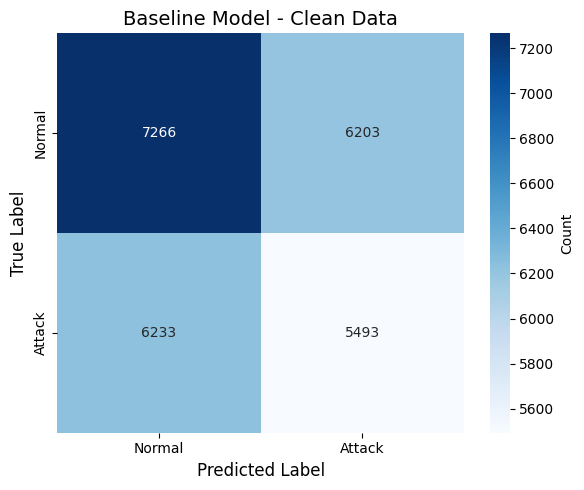

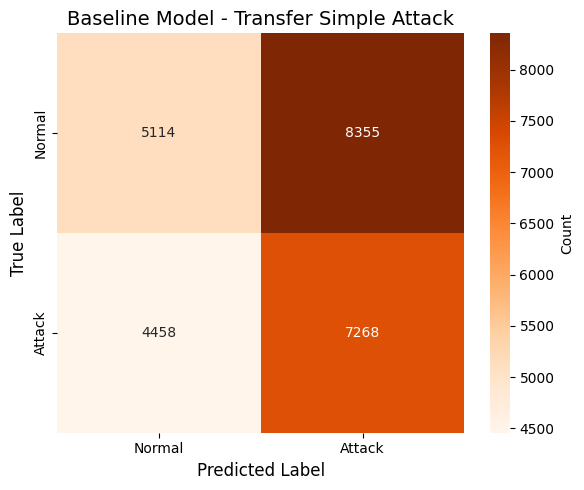

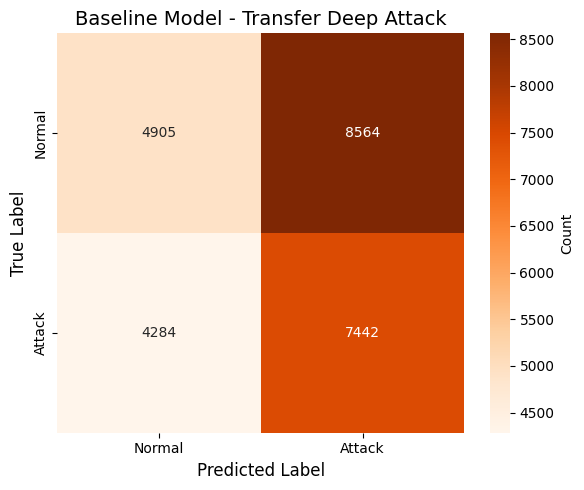

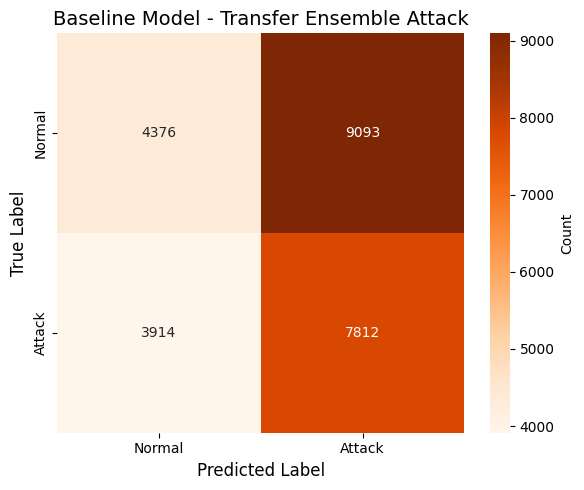

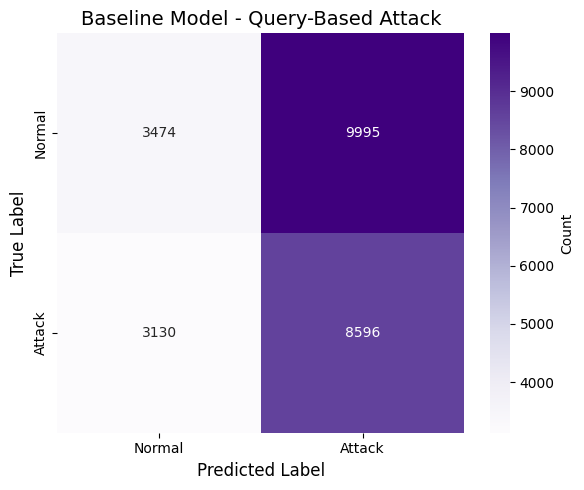

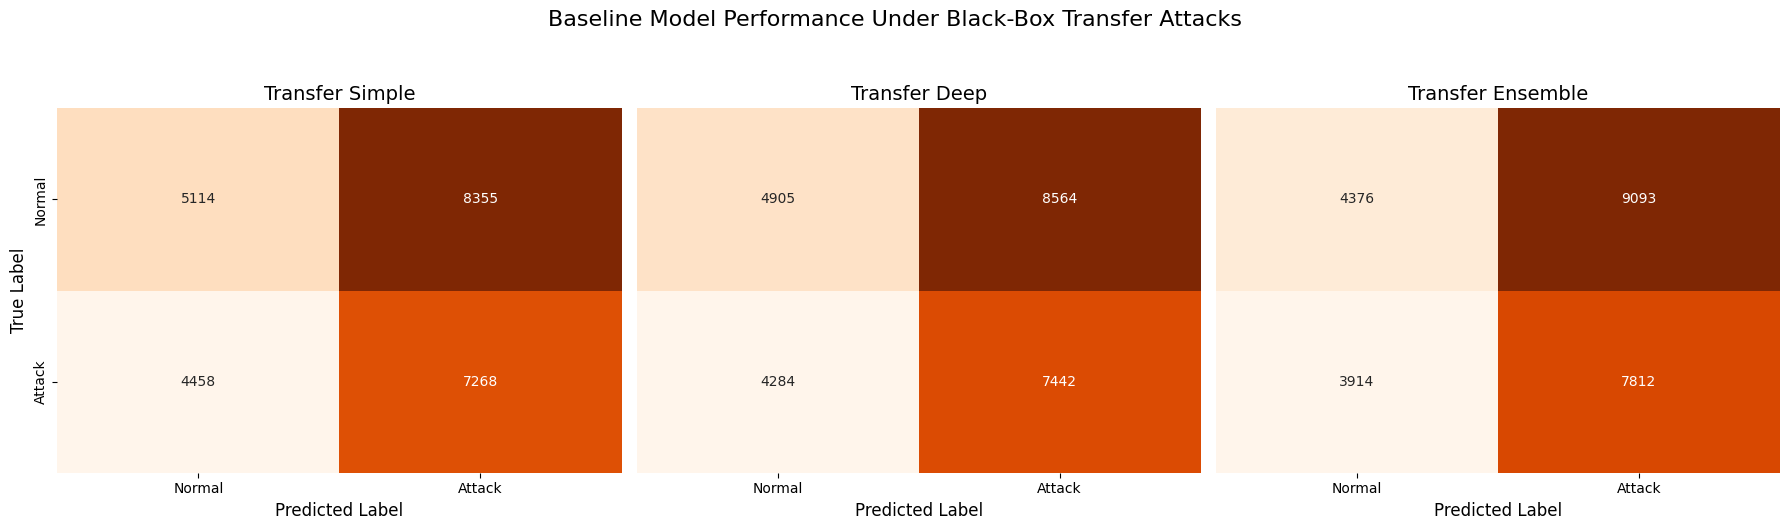

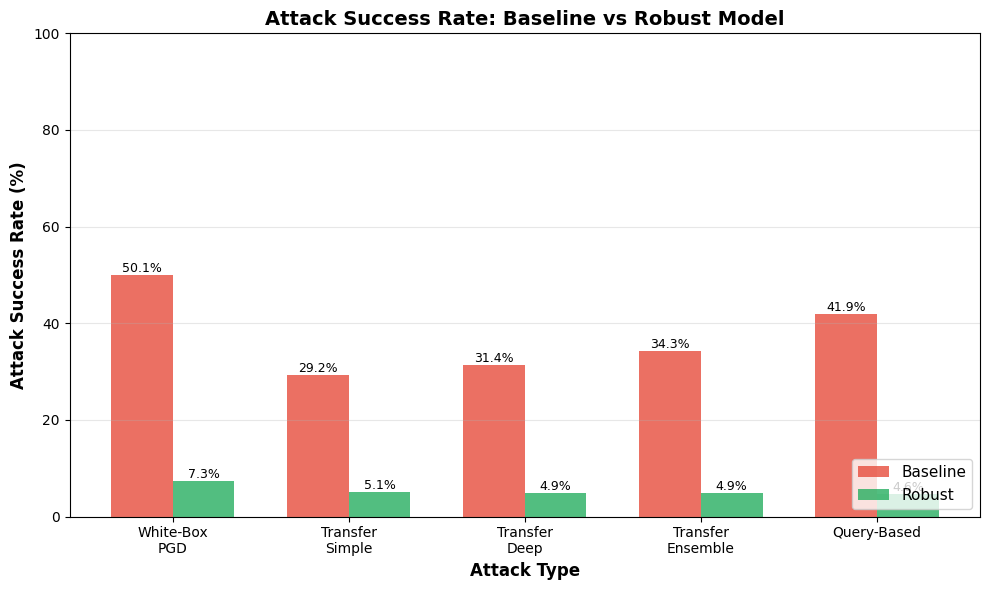

In [9]:
# ==========================================
# REPORT FIGURES GENERATION
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure results directory exists
if not os.path.exists('results'):
    os.makedirs('results')

# ---------------------------------------------------------
# Data Loading Helper (if y_test is missing)
# ---------------------------------------------------------
if 'y_test' not in locals():
    print("⚠️ 'y_test' not found in memory. Attempting to reload data...")
    try:
        # Replicate data loading logic to ensure consistency
        NSL_KDD_COLUMNS = [
            'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
            'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
            'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
            'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
            'num_access_files', 'num_outbound_cmds', 'is_host_login',
            'is_guest_login', 'count', 'srv_count', 'serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
            'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
            'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
            'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
            'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
            'dst_host_srv_rerror_rate', 'outcome', 'level'
        ]
        CATEGORICAL_COLUMNS = ['protocol_type', 'service', 'flag']
        TARGET_COLUMN = 'outcome'
        DROP_COLUMNS = ['outcome', 'level']
        
        def load_and_preprocess_test_data(filepath, seed=9281):
            df = pd.read_csv(filepath, header=None)
            df.columns = NSL_KDD_COLUMNS
            
            # Preprocessing
            for col in ['duration', 'wrong_fragment']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df = df.fillna(0)
            
            df[TARGET_COLUMN] = (df[TARGET_COLUMN] != "normal").astype(int)
            
            # Split (must match original experiment)
            _, df_test = train_test_split(
                df, test_size=0.2, random_state=seed, stratify=df[TARGET_COLUMN]
            )
            
            y_test_loaded = df_test[TARGET_COLUMN].values
            return y_test_loaded

        y_test = load_and_preprocess_test_data('KDDTrain+.txt')
        print("✓ 'y_test' successfully reconstructed from 'KDDTrain+.txt'")
        
    except Exception as e:
        print(f"❌ Failed to reload data: {e}")
        print("Please run the data loading cells (Section 2) at the beginning of the notebook.")

# ---------------------------------------------------------
# Load Saved Results (Pickle & CSV)
# ---------------------------------------------------------
# 1. Load Pickle for Confusion Matrices (needs y_pred)
try:
    with open('results/all_results.pkl', 'rb') as f:
        saved_results = pickle.load(f)
    print("✓ Loaded 'results/all_results.pkl' for confusion matrices.")
    
    res_baseline = saved_results.get('baseline_clean', None)
    res_simple = saved_results.get('baseline_transfer_simple', None)
    res_deep = saved_results.get('baseline_transfer_deep', None)
    res_ensemble = saved_results.get('baseline_transfer_ensemble', None)
    res_query = saved_results.get('baseline_transfer_query', None)
    res_semantic = saved_results.get('baseline_whitebox', None) # Might be missing
    
    # Fallback for semantic if missing in pickle but present in memory
    if res_semantic is None and 'semantic_results' in locals(): 
        res_semantic = semantic_results

except (FileNotFoundError, NameError):
    print("⚠️ Pickle file not found. Using memory variables for confusion matrices.")
    # Fallback to memory
    res_baseline = locals().get('baseline_results', None)
    res_simple = locals().get('transfer_results', {}).get('simple', None)
    res_deep = locals().get('transfer_results', {}).get('deep', None)
    res_ensemble = locals().get('transfer_results', {}).get('ensemble', None)
    res_query = locals().get('transfer_results', {}).get('query_based', None)
    res_semantic = locals().get('semantic_results', None)

# 2. Load CSV for Attack Success Rate Graph (ensures match with summary table)
try:
    df_summary = pd.read_csv('results/summary_table.csv')
    print("✓ Loaded 'results/summary_table.csv' for ASR graph consistency.")
    use_csv_for_asr = True
except FileNotFoundError:
    print("⚠️ 'results/summary_table.csv' not found. Calculating ASR from results.")
    use_csv_for_asr = False

# ---------------------------------------------------------
# Figure 2: Baseline Confusion Matrix (Clean Data)
# ---------------------------------------------------------
if res_baseline is not None:
    cm_baseline_clean = confusion_matrix(y_test, res_baseline['y_pred'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_baseline_clean, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'],
                cbar_kws={'label': 'Count'})
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title('Baseline Model - Clean Data', fontsize=14)
    plt.tight_layout()
    plt.savefig('results/confusion_matrix_baseline_clean.png', dpi=300)
    plt.show()

# ---------------------------------------------------------
# Figure 3: Baseline Under White-Box Attack Confusion Matrix
# ---------------------------------------------------------
if res_semantic is not None:
    cm_baseline_attack = confusion_matrix(y_test, res_semantic['y_pred'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_baseline_attack, annot=True, fmt='d', cmap='Reds',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'],
                cbar_kws={'label': 'Count'})
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title('Baseline Model - Under White-Box PGD Attack', fontsize=14)
    plt.tight_layout()
    plt.savefig('results/confusion_matrix_baseline_attack.png', dpi=300)
    plt.show()

# ---------------------------------------------------------
# Additional Confusion Matrices for Transfer Attacks
# ---------------------------------------------------------
def plot_cm(res, title, filename, cmap='Oranges'):
    if res is not None:
        cm = confusion_matrix(y_test, res['y_pred'])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                    xticklabels=['Normal', 'Attack'],
                    yticklabels=['Normal', 'Attack'],
                    cbar_kws={'label': 'Count'})
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.title(title, fontsize=14)
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
        plt.show()

plot_cm(res_simple, 'Baseline Model - Transfer Simple Attack', 'results/confusion_matrix_transfer_simple.png')
plot_cm(res_deep, 'Baseline Model - Transfer Deep Attack', 'results/confusion_matrix_transfer_deep.png')
plot_cm(res_ensemble, 'Baseline Model - Transfer Ensemble Attack', 'results/confusion_matrix_transfer_ensemble.png')
plot_cm(res_query, 'Baseline Model - Query-Based Attack', 'results/confusion_matrix_query_based.png', cmap='Purples')

# Combined Confusion Matrix for Black-Box Transfer Attacks
if res_simple is not None and res_deep is not None and res_ensemble is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Simple
    cm_simple = confusion_matrix(y_test, res_simple['y_pred'])
    sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'], cbar=False)
    axes[0].set_title('Transfer Simple', fontsize=14)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    
    # Deep
    cm_deep = confusion_matrix(y_test, res_deep['y_pred'])
    sns.heatmap(cm_deep, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'], cbar=False)
    axes[1].set_title('Transfer Deep', fontsize=14)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_yticks([]) # Hide y-axis labels for middle plot
    
    # Ensemble
    cm_ensemble = confusion_matrix(y_test, res_ensemble['y_pred'])
    sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'], cbar=False)
    axes[2].set_title('Transfer Ensemble', fontsize=14)
    axes[2].set_xlabel('Predicted Label', fontsize=12)
    axes[2].set_yticks([]) # Hide y-axis labels for right plot
    
    plt.suptitle('Baseline Model Performance Under Black-Box Transfer Attacks', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.savefig('results/confusion_matrix_transfer_combined.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Skipping Combined Transfer Matrix: One or more transfer results missing.")

# ---------------------------------------------------------
# Figure 4: Attack Success Rate Comparison
# ---------------------------------------------------------
attack_types = ['White-Box\nPGD', 'Transfer\nSimple', 'Transfer\nDeep', 
                'Transfer\nEnsemble', 'Query-Based']

if use_csv_for_asr:
    # Map CSV scenarios to our plot labels
    scenario_map = {
        'White-Box\nPGD': 'White-Box PGD (Semantic)',
        'Transfer\nSimple': 'Transfer Simple (Semantic)',
        'Transfer\nDeep': 'Transfer Deep (Semantic)',
        'Transfer\nEnsemble': 'Transfer Ensemble (Semantic)',
        'Query-Based': 'Transfer Query-Based (Semantic)'
    }
    
    baseline_asr = []
    robust_asr = []
    
    for attack in attack_types:
        csv_scenario = scenario_map.get(attack)
        row = df_summary[df_summary['Scenario'] == csv_scenario]
        
        if not row.empty:
            # ASR = (1 - Accuracy) * 100
            b_acc = row['Baseline Accuracy'].values[0]
            r_acc = row['Robust Accuracy'].values[0]
            baseline_asr.append((1 - b_acc) * 100)
            robust_asr.append((1 - r_acc) * 100)
        else:
            baseline_asr.append(0)
            robust_asr.append(0)
            print(f"⚠️ Warning: Scenario '{csv_scenario}' not found in CSV.")

else:
    # Fallback calculation
    def calculate_asr(results_dict):
        if results_dict is None: return 0
        return (1 - results_dict['accuracy']) * 100

    # Try to get robust results from memory or pickle
    try:
        res_robust_wb = saved_results.get('robust_whitebox', locals().get('robust_whitebox_results'))
        res_robust_simple = saved_results.get('robust_transfer_simple', locals().get('robust_transfer_simple'))
        res_robust_deep = saved_results.get('robust_transfer_deep', locals().get('robust_transfer_deep'))
        res_robust_ensemble = saved_results.get('robust_transfer_ensemble', locals().get('robust_transfer_ensemble'))
        res_robust_query = saved_results.get('robust_transfer_query', locals().get('robust_transfer_query'))
    except:
        res_robust_wb = None

    baseline_asr = [
        calculate_asr(res_semantic),
        calculate_asr(res_simple),
        calculate_asr(res_deep),
        calculate_asr(res_ensemble),
        calculate_asr(res_query)
    ]

    robust_asr = [
        calculate_asr(res_robust_wb),
        calculate_asr(res_robust_simple),
        calculate_asr(res_robust_deep),
        calculate_asr(res_robust_ensemble),
        calculate_asr(res_robust_query)
    ]

x = np.arange(len(attack_types))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, baseline_asr, width, label='Baseline', 
               color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, robust_asr, width, label='Robust', 
               color='#27ae60', alpha=0.8)

ax.set_ylabel('Attack Success Rate (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Attack Type', fontsize=12, fontweight='bold')
ax.set_title('Attack Success Rate: Baseline vs Robust Model', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(attack_types)
ax.legend(fontsize=11, loc='lower right')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('results/attack_success_rate_comparison.png', dpi=300)
plt.show()